In [1]:
import numpy
import pandas
import seaborn
import logging
import time
import collections
import os
from os import environ
from matplotlib import pyplot

import sklearn
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.linear_model

from six import string_types

%matplotlib inline
logging.basicConfig(level="DEBUG")

pandas.set_option('display.max_columns', 60)

from mhc2flurry.downloads import get_path
import mhc2flurry

from copy import deepcopy
import shutil
from Bio import SeqIO
import bz2

import tensorflow as tf
#config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
#session = tf.Session(config=config)
#K.set_session(session)

def ppv(y_true, predictions):
    df = pandas.DataFrame({"prediction": predictions, "y_true": y_true})
    return df.sort_values("prediction", ascending=False)[:int(y_true.sum())].y_true.mean()

import Bio.SeqIO
import traceback
from gzip import GzipFile
import Bio
import Bio.SeqUtils
from glob import glob
import json
from scipy.stats import pearsonr

import tqdm

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

import mhcgnomes

import mhc2flurry.allele_encoding_pair
import mhc2flurry.allele_encoding
import mhc2flurry.fasta


from mhcflurry.regression_target import from_ic50, to_ic50

DEBUG:root:Configured MHC2FLURRY_DOWNLOADS_DIR: /home/odonnt02/.local/share/mhc2flurry/1/0.0.1
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:root:Configured MHCFLURRY_DOWNLOADS_DIR: /home/odonnt02/.local/share/mhcflurry/4/2.0.0


In [2]:
!ls "$(mhc2flurry-downloads path data_curated)"

annotate_proteins.py				DOWNLOAD_INFO.csv
curated_training_data.affinity.csv.bz2		expression
curated_training_data.csv.bz2			GENERATE.sh
curated_training_data.mass_spec.csv.bz2		LOG.txt.bz2
curated_training_data.no_additional_ms.csv.bz2	ms.by_pmid.csv.bz2
curate_ms_by_pmid.py				rna_expression.csv.bz2
curate.py					rna_expression.metadata.csv.bz2


In [3]:
!cat "$(mhc2flurry-downloads path data_curated)/DOWNLOAD_INFO.csv"

url
https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/data_curated.20210305.tar.bz2


In [4]:
!mhc2flurry-downloads info

Environment variables
  MHC2FLURRY_DATA_DIR                 [unset or empty]
  MHC2FLURRY_DOWNLOADS_CURRENT_RELEASE [unset or empty]
  MHC2FLURRY_DOWNLOADS_DIR            [unset or empty]
  MHC2FLURRY_DEFAULT_MODELS_DIR       [unset or empty]
  MHC2FLURRY_DOWNLOADS_GITHUB_AUTH_TOKEN [unset or empty]

Configuration
  current release                     = 0.0.1                
  downloads dir                       = /home/odonnt02/.local/share/mhc2flurry/1/0.0.1 [exists]

DOWNLOAD NAME                             DOWNLOADED?   UP TO DATE?   URL                  
allele_sequences                          YES           YES           https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/allele_sequences.20210222.tar.bz2 
data_curated                              YES           YES           https://github.com/openvax/mhc2flurry/releases/download/pre-0.0.1/data_curated.20210305.tar.bz2 
data_published                            YES           YES           https://github.com/openva

In [5]:
train_df = pandas.read_csv(get_path("data_curated", "curated_training_data.csv.bz2"))
train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,proteins_human,proteins_mouse,proteins_viral
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|O92532|POLG_HCVVP sp|P...
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|Q03463|POLG_HCVJ1 sp|P26664|POLG_HCV1
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|P26664|POLG_HCV1
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|O92532|POLG_HCVVP sp|Q...
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|Q9WMX2|POLG_HCVCO sp|Q...
...,...,...,...,...,...,...,...,...,...,...,...
311559,SLA-DRB1*10:01,THVLTNLPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311560,SLA-DRB1*10:01,VSHLPVFFSHLFKSDSGYS,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311561,SLA-DRB1*10:01,WGFAAFTLF,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311562,SLA-DRB1*10:01,YEASPLAPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN


In [6]:
train_df.measurement_type.value_counts()
train_df.measurement_source.value_counts()
train_df.measurement_kind.value_counts()
train_df.loc[train_df.measurement_kind == "mass_spec"].measurement_source.value_counts()


Falkenburg - cellular MHC/mass spectrometry             81031
Neidert - cellular MHC/mass spectrometry                45387
MS:pmid:31495665                                        43332
Sollid - cellular MHC/mass spectrometry                 18926
Alizadeh - cellular MHC/mass spectrometry                4058
                                                        ...  
Sollid - secreted MHC/mass spectrometry                     4
Urbaniak - secreted MHC/mass spectrometry                   4
Poland - secreted MHC/mass spectrometry                     2
LeibundGut-Landmann - secreted MHC/mass spectrometry        2
Purcell - cellular MHC/mass spectrometry                    1
Name: measurement_source, Length: 61, dtype: int64

In [7]:
train_df.loc[train_df.measurement_source.str.startswith("MS:pmid")].measurement_source.value_counts()

MS:pmid:31495665    43332
Name: measurement_source, dtype: int64

In [8]:
train_df.loc[train_df.measurement_kind == "mass_spec"].measurement_inequality.value_counts()

<    211651
Name: measurement_inequality, dtype: int64

In [9]:
train_df.loc[train_df.measurement_source.str.contains("Falkenburg")].measurement_inequality.value_counts()

<    81031
Name: measurement_inequality, dtype: int64

In [10]:
train_ms_df = pandas.read_csv(get_path("data_curated", "ms.by_pmid.csv.bz2"))
train_ms_df = train_ms_df.loc[
    train_ms_df.mhc_class == "II"
]
train_ms_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral
0,29314611,MAVER-1_DR,TPEQWKSHKSYSCQVTHEGSTVEK,DR-SPECIFIC,II,HLA-DRB1*01:01 HLA-DRB1*13:01 HLA-DRB3*02:02 H...,sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,NaN,NaN,NaN
1,29314611,MAVER-1_DR,KPISKAVIVLNEGIKVQTKE,DR-SPECIFIC,II,HLA-DRB1*01:01 HLA-DRB1*13:01 HLA-DRB3*02:02 H...,sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,sp|O75976-2|CBPD-2_HUMAN,NaN,NaN
2,29314611,MAVER-1_DR,DPSAVAKHFVALSTNTTKVKE,DR-SPECIFIC,II,HLA-DRB1*01:01 HLA-DRB1*13:01 HLA-DRB3*02:02 H...,sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,tr|A0A2R8Y6C7|A0A2R8Y6C7_HUMAN sp|P06744-2|G6P...,NaN,NaN
3,29314611,MAVER-1_DR,VSKALHKAALTIDEKGTEAVGSTFLE,DR-SPECIFIC,II,HLA-DRB1*01:01 HLA-DRB1*13:01 HLA-DRB3*02:02 H...,sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,NaN,NaN,NaN
4,29314611,MAVER-1_DR,TPEQWKSHKSYSCQVTHEGSTVEKTVAPTE,DR-SPECIFIC,II,HLA-DRB1*01:01 HLA-DRB1*13:01 HLA-DRB3*02:02 H...,sample_type:B-CELL,MAVER-1,29314611,L243 (HLA-DR),B-CELL,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337967,31611696,3912_BAM-HLA-DR-DEPLETED,YYYIQQDTKGDYQKA,DR-DEPLETED,II,HLA-DRB1*03:01 HLA-DRB1*04:01 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,sp|P07355-2|ANXA2-2_HUMAN,tr|B0V2N5|B0V2N5_MOUSE,NaN
337968,31611696,4052_BA-HLA-DR,YYYIQQDTKGDYQKA,DR-SPECIFIC,II,HLA-DRB1*03:01 HLA-DRB1*11:04 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,31611696,HB298,MENINGIOMA,sp|P07355-2|ANXA2-2_HUMAN,tr|B0V2N5|B0V2N5_MOUSE,NaN
337969,31611696,4052_BA-HLA-DR-DEPLETED,YYYIQQDTKGDYQKA,DR-DEPLETED,II,HLA-DRB1*03:01 HLA-DRB1*11:04 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,31611696,NaN,MENINGIOMA,sp|P07355-2|ANXA2-2_HUMAN,tr|B0V2N5|B0V2N5_MOUSE,NaN
337970,31611696,3912_BAM-HLA-DR,YYYIQQDTKGDYQKAL,DR-SPECIFIC,II,HLA-DRB1*03:01 HLA-DRB1*04:01 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,31611696,HB298,MENINGIOMA,sp|P07355-2|ANXA2-2_HUMAN,tr|B0V2N5|B0V2N5_MOUSE,NaN


In [11]:
train_ms_df.original_pmid.value_counts()

31611696    243301
31495665     66607
29314611     28064
Name: original_pmid, dtype: int64

In [12]:
affinity_df = train_df.loc[
    (~train_df.peptide.isin(train_ms_df.peptide)) &
    (train_df.measurement_kind == "affinity")
]
affinity_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,proteins_human,proteins_mouse,proteins_viral
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|O92532|POLG_HCVVP sp|P...
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|Q03463|POLG_HCVJ1 sp|P26664|POLG_HCV1
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|P26664|POLG_HCV1
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|O92532|POLG_HCVVP sp|Q...
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|Q9WMX2|POLG_HCVCO sp|Q...
...,...,...,...,...,...,...,...,...,...,...,...
311559,SLA-DRB1*10:01,THVLTNLPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311560,SLA-DRB1*10:01,VSHLPVFFSHLFKSDSGYS,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311561,SLA-DRB1*10:01,WGFAAFTLF,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311562,SLA-DRB1*10:01,YEASPLAPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN


In [13]:
allele_sequences_df = pandas.read_csv(get_path("allele_sequences", "allele_sequences.csv"), index_col=0)
allele_sequences_variant = allele_sequences_df.columns[0]
print("using variant", allele_sequences_variant)
allele_sequences_alpha = allele_sequences_df.loc[allele_sequences_df.kind == "alpha", allele_sequences_variant]
allele_sequences_beta = allele_sequences_df.loc[allele_sequences_df.kind == "beta", allele_sequences_variant]
allele_sequences_alpha, allele_sequences_beta

using variant maf_0.2_and_0.3_within_6.0_angstrom


(sequence_id
 HLA-DPA1*02:38Q    SYMFFQRAFSEGGAIILNTL
 HLA-DPA1*01:03     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:03Q    SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:14     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:18     SYAFFMQAFSEGGAIILNTL
                            ...         
 HLA-DPA1*01:46     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:05     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*01:41     SYAFFMQAFSEGGAIILNTL
 HLA-DPA1*02:03     SYAFFMRAFSEGGAIILNTL
 HLA-DPA1*02:16     SYAFFQRAFSEGGAIILNTL
 Name: maf_0.2_and_0.3_within_6.0_angstrom, Length: 174, dtype: object,
 sequence_id
 HLA-DQB1*05:03      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:08      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:10      YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:108     YFGGTHYVYDVGASRVEVAYGI
 HLA-DQB1*05:134     YFGGTHYVYDVGASRVEVAYGI
                              ...          
 HLA-DQB1*03:422N    YFGLTYYAYAVRTETVQLELTT
 HLA-DRB1*12:06      ESGLEHLLFVIDRATYGAVEFT
 HLA-DRB4*01:124     EACNIYYAYDLRRETYGVVEFT
 HLA-DRB5*01:08N     QDYFHGNVYDFDRATYGVGEFT
 HLA-DQB1*0

In [14]:
mhcgnomes.parse("Patr-DRB1*03:08", infer_class2_pairing=True)

Allele(gene=Gene(species=Species(name='Pan troglodytes', mhc_prefix='Patr'), name='DRB1'), allele_fields=('03', '08'), annotations=(), mutations=())

In [15]:
mhcgnomes.parse("HLA-DRB1*03:08", infer_class2_pairing=True)

Class2Pair(alpha=Allele(gene=Gene(species=Species(name='Homo sapiens', mhc_prefix='HLA'), name='DRA'), allele_fields=('01', '01'), annotations=(), mutations=()), beta=Allele(gene=Gene(species=Species(name='Homo sapiens', mhc_prefix='HLA'), name='DRB1'), allele_fields=('03', '08'), annotations=(), mutations=()), mhc_class='IIa')

In [16]:
train_df.loc[
    ~train_df.peptide.isin(train_ms_df.peptide)
]

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,proteins_human,proteins_mouse,proteins_viral
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|O92532|POLG_HCVVP sp|P...
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|Q03463|POLG_HCVJ1 sp|P26664|POLG_HCV1
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|P26664|POLG_HCV1
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|O92532|POLG_HCVVP sp|Q...
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|Q9WMX2|POLG_HCVCO sp|Q...
...,...,...,...,...,...,...,...,...,...,...,...
311559,SLA-DRB1*10:01,THVLTNLPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311560,SLA-DRB1*10:01,VSHLPVFFSHLFKSDSGYS,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311561,SLA-DRB1*10:01,WGFAAFTLF,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN
311562,SLA-DRB1*10:01,YEASPLAPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN


In [17]:
train_df["parsed_allele"] = train_df.allele.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True))
train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,proteins_human,proteins_mouse,proteins_viral,parsed_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|O92532|POLG_HCVVP sp|P...,Allele(gene=Gene(species=Species(name='Bos sp....
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|Q03463|POLG_HCVJ1 sp|P26664|POLG_HCV1,Allele(gene=Gene(species=Species(name='Bos sp....
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|P26664|POLG_HCV1,Allele(gene=Gene(species=Species(name='Bos sp....
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|O92532|POLG_HCVVP sp|Q...,Allele(gene=Gene(species=Species(name='Bos sp....
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,NaN,NaN,sp|O92972|POLG_HCVJ4 sp|Q9WMX2|POLG_HCVCO sp|Q...,Allele(gene=Gene(species=Species(name='Bos sp....
...,...,...,...,...,...,...,...,...,...,...,...,...
311559,SLA-DRB1*10:01,THVLTNLPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN,Allele(gene=Gene(species=Species(name='Sus sp....
311560,SLA-DRB1*10:01,VSHLPVFFSHLFKSDSGYS,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN,Allele(gene=Gene(species=Species(name='Sus sp....
311561,SLA-DRB1*10:01,WGFAAFTLF,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN,Allele(gene=Gene(species=Species(name='Sus sp....
311562,SLA-DRB1*10:01,YEASPLAPL,100.0,<,qualitative,affinity,Meng - cellular MHC/direct/fluorescence,SLA-DRB1*10:01,NaN,NaN,NaN,Allele(gene=Gene(species=Species(name='Sus sp....


In [18]:
use_train_df = train_df.loc[train_df.parsed_allele.map(lambda p: isinstance(p, mhcgnomes.Class2Pair))].copy()
use_train_df["alpha_allele"] = use_train_df.parsed_allele.map(lambda p: p.alpha.to_string())
use_train_df["beta_allele"] = use_train_df.parsed_allele.map(lambda p: p.beta.to_string())

use_train_df = use_train_df.loc[
    (use_train_df.alpha_allele.isin(allele_sequences_alpha.index)) &
    (use_train_df.beta_allele.isin(allele_sequences_beta.index))
].copy()

use_train_df = use_train_df.loc[
    (use_train_df.measurement_kind == "affinity")
].copy()
use_train_df["allele"] = use_train_df.allele.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True).to_string())
use_train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,proteins_human,proteins_mouse,proteins_viral,parsed_allele,alpha_allele,beta_allele
9947,HLA-DPA1*01:03-DPB1*02:01,AAAAGWQTLSAALDA,3770.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9949,HLA-DPA1*01:03-DPB1*02:01,AAAGAEAGKATTEEQ,46700.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9964,HLA-DPA1*01:03-DPB1*02:01,AAASVPAADKFKTFE,5520.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9965,HLA-DPA1*01:03-DPB1*02:01,AAATATATAAVGAAT,46700.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9967,HLA-DPA1*01:03-DPB1*02:01,AADHAAPEDKYEAFV,781.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310179,HLA-DRA*01:01-DRB5*01:02,VSILQTASSGLTSLTNSLQR,5000.0,<,qualitative,affinity,Robinson - purified MHC/direct/fluorescence,HLA-DRB5*01:02,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
310180,HLA-DRA*01:01-DRB5*01:02,VTAVFGSSTAGTGTAASPSF,5000.0,<,qualitative,affinity,Robinson - purified MHC/direct/fluorescence,HLA-DRB5*01:02,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
310181,HLA-DRA*01:01-DRB5*01:02,VTPRTPPPSQGKGRGLSLSR,20000.0,>,quantitative,affinity,Adorini - purified MHC/competitive/radioactivity,HLA-DRB5*01:02,tr|A8MZH3|A8MZH3_HUMAN tr|C9J6H1|C9J6H1_HUMAN ...,sp|P04370-4|MBP-4_MOUSE sp|P04370-5|MBP-5_MOUS...,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
310182,HLA-DRA*01:01-DRB5*01:02,YKSAHKGFKGVDAQGTLSKI,4100.0,=,quantitative,affinity,Adorini - purified MHC/competitive/radioactivity,HLA-DRB5*01:02,tr|A8MZH3|A8MZH3_HUMAN tr|C9J6H1|C9J6H1_HUMAN ...,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02


In [19]:
use_train_df.allele.value_counts()

HLA-DRA*01:01-DRB1*01:01     10741
HLA-DRA*01:01-DRB1*04:01      6208
HLA-DRA*01:01-DRB1*03:01      5245
HLA-DRA*01:01-DRB1*07:01      5178
HLA-DRA*01:01-DRB1*11:01      5105
                             ...  
HLA-DQA1*01:02-DQB1*06:03        2
HLA-DRA*01:01-DRB1*13:05         1
HLA-DQA1*01:01-DQB1*05:03        1
HLA-DRA*01:01-DRB1*04:08         1
HLA-DRA*01:01-DRB1*03:04         1
Name: allele, Length: 103, dtype: int64

In [20]:
validation_df = train_ms_df.loc[
    (train_ms_df.format == "MONOALLELIC") &
    (~train_ms_df.peptide.isin(use_train_df.peptide))
].copy()
validation_df["parsed_allele"] = validation_df.hla.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True))

validation_df = validation_df.loc[validation_df.parsed_allele.map(lambda p: isinstance(p, mhcgnomes.Class2Pair))].copy()
validation_df["alpha_allele"] = validation_df.parsed_allele.map(lambda p: p.alpha.to_string())
validation_df["beta_allele"] = validation_df.parsed_allele.map(lambda p: p.beta.to_string())

validation_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral,parsed_allele,alpha_allele,beta_allele
28064,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
28065,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|O95479-2|G6PE-2_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
28066,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
28067,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|P09912-2|IFI6-2_HUMAN sp|P09912-3|IFI6-3_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
28068,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q9UII2-2|ATIF1-2_HUMAN sp|Q9UII2-3|ATIF1-3_...,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73695,31495665,MAPTAC_DRB1*15:01,AQNVGTTHDL,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,tr|J3KS79|J3KS79_HUMAN tr|K7ENH5|K7ENH5_HUMAN ...,tr|E9PZH4|E9PZH4_MOUSE tr|E9Q6V3|E9Q6V3_MOUSE,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
73696,31495665,MAPTAC_DRB1*15:01,YPHRPVLMVISHAAPHGPE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q8IWU5-2|SULF2-2_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
73697,31495665,MAPTAC_DRB1*15:01,KQERISRYQGVNLYIKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,tr|H0YEU6|H0YEU6_HUMAN tr|H0Y5F5|H0Y5F5_HUMAN ...,tr|A3KFU5|A3KFU5_MOUSE tr|A3KFU8|A3KFU8_MOUSE ...,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
73698,31495665,MAPTAC_DRB1*15:01,QDEHFLGIESLWNHKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q8IY82-2|DRC7-2_HUMAN tr|H3BRR8|H3BRR8_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01


In [21]:
validation_df.hla.value_counts()

HLA-DRA*01:01-DRB1*11:01     10021
HLA-DRA*01:01-DRB1*01:01      8032
HLA-DPA1*01:03-DPB1*06:01     5960
HLA-DRA*01:01-DRB1*07:01      5685
HLA-DRA*01:01-DRB1*15:01      3428
HLA-DRA*01:01-DRB3*01:01      2612
HLA-DRA*01:01-DRB1*03:01      2590
HLA-DRA*01:01-DRB1*12:01      2500
HLA-DRA*01:01-DRB1*04:01      2446
HLA-DQA1*01:02-DQB1*06:04     2219
Name: hla, dtype: int64

In [22]:
allele = "HLA-DRA*01:01-DRB1*01:01"
validation_df.loc[validation_df.hla == allele].shape, use_train_df.loc[use_train_df.allele == allele].shape

((8032, 17), (10741, 14))

In [23]:
allele_sequences_alpha.to_dict()

{'HLA-DPA1*02:38Q': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*01:03': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:03Q': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:14': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:18': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:19': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:20': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:30': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:31': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:33': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:42': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:44': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*01:49': 'SYAFFMQAFSEGGAIILNTL',
 'HLA-DPA1*02:01': 'SYAFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:02': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:06': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:07': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:08': 'SYAFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:09': 'SYAFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:10': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:12': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:14': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA1*02:15': 'SYMFFQRAFSEGGAIILNTL',
 'HLA-DPA

In [24]:
import mhc2flurry.allele_encoding_pair
import mhc2flurry.allele_encoding

allele_encoding_pair = mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_train_df.alpha_allele.values,
        allele_to_sequence=allele_sequences_alpha.to_dict()),
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_train_df.beta_allele.values,
        allele_to_sequence=allele_sequences_beta.to_dict()))
allele_encoding_pair

In [25]:
use_train_df.groupby("allele").measurement_value.median().sort_values()

allele
HLA-DRA*01:01-DRB1*08:04       100.0
HLA-DRA*01:01-DRB1*01:02       100.0
HLA-DRA*01:01-DRB1*03:04       100.0
HLA-DRA*01:01-DRB1*03:05       100.0
HLA-DQA1*01:02-DQB1*03:19      100.0
                              ...   
HLA-DQA1*01:03-DQB1*03:02     9850.0
HLA-DQA1*01:03-DQB1*06:03    10000.0
HLA-DQA1*03:02-DQB1*03:03    13300.0
HLA-DQA1*01:01-DQB1*05:01    13400.0
HLA-DQA1*02:01-DQB1*02:01    15000.0
Name: measurement_value, Length: 103, dtype: float64

In [26]:
import imp
import mhc2flurry.condconv
imp.reload(mhc2flurry.condconv)

import mhc2flurry.class2_neural_network
imp.reload(mhc2flurry.class2_neural_network)
import mhc2flurry.class2_neural_network


model = mhc2flurry.class2_neural_network.Class2NeuralNetwork(
    random_negative_rate=1.0,
    random_negative_binder_threshold=2000,
    layer_sizes=[8],
    patience=5,
    peptide_convolutions=[
        {'kernel_size': 9, 'filters': 64, 'activation': "relu"},
        {'kernel_size': 1, 'filters': 16, 'activation': "relu"},
        {'kernel_size': 16, 'filters': 16, 'activation': "relu"},
    ],
)
print(model.hyperparameters)

model.fit(
    use_train_df.peptide.values,
    affinities=from_ic50(use_train_df["measurement_value"].values),
    inequalities=use_train_df["measurement_inequality"].values,
    allele_encoding_pair=allele_encoding_pair
)

{'random_negative_rate': 1.0, 'random_negative_binder_threshold': 2000, 'layer_sizes': [8], 'patience': 5, 'peptide_convolutions': [{'kernel_size': 9, 'filters': 64, 'activation': 'relu'}, {'kernel_size': 1, 'filters': 16, 'activation': 'relu'}, {'kernel_size': 16, 'filters': 16, 'activation': 'relu'}], 'allele_amino_acid_encoding': 'BLOSUM62', 'allele_dense_layer_sizes': [], 'allele_positionwise_embedding_size': 32, 'peptide_encoding': {'vector_encoding_name': 'BLOSUM62', 'alignment_method': 'right_pad', 'max_length': 50}, 'dense_layer_l1_regularization': 0.001, 'dense_layer_l2_regularization': 0.0, 'activation': 'tanh', 'init': 'glorot_uniform', 'output_activation': 'sigmoid', 'dropout_probability': 0.0, 'batch_normalization': False, 'topology': 'feedforward', 'num_outputs': 1, 'loss': 'custom:mse_with_inequalities', 'optimizer': 'rmsprop', 'learning_rate': None, 'max_epochs': 500, 'validation_split': 0.1, 'early_stopping': True, 'minibatch_size': 128, 'data_dependent_initialization_

INFO:root:Using amino acid distribution for random negative:
{'A': 0.09266371665256584, 'G': 0.0718993234986004, 'W': 0.015039526266419682, 'Q': 0.03479488204339537, 'T': 0.05731900392050246, 'L': 0.09218083951639246, 'S': 0.06364104239241951, 'D': 0.04546687253193313, 'E': 0.05878657168730392, 'K': 0.06832846736555355, 'V': 0.06887221136763114, 'P': 0.048000286750568256, 'F': 0.04167148529355075, 'H': 0.02173285262035239, 'Y': 0.03261720084104483, 'N': 0.04291993234309705, 'I': 0.05489717895602504, 'R': 0.04783526991411685, 'C': 0.014765625369850748, 'M': 0.026567710668676626}
INFO:root:Random negative plan [by_allele]:
                                   8    9    10   11   12   13   14   15
(HLA-DPA1*01:03, HLA-DPB1*01:01)   14   14   14   14   14   14   14   14
(HLA-DPA1*01:03, HLA-DPB1*02:01)  122  122  122  122  122  122  122  122
(HLA-DPA1*01:03, HLA-DPB1*03:01)   35   35   35   35   35   35   35   35
(HLA-DPA1*01:03, HLA-DPB1*04:01)  126  126  126  126  126  126  126  126
(HLA-D

Model: "predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
alpha_allele (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
beta_allele (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
alpha_allele_representation (Em (None, 1, 420)       73500       alpha_allele[0][0]               
__________________________________________________________________________________________________
beta_allele_representation (Emb (None, 1, 462)       571494      beta_allele[0][0]                
__________________________________________________________________________________________

1206/1206 [==============================] - 13s 11ms/step - loss: 0.0299 - output_loss: 0.0147 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.0457 - val_output_loss: 0.0305 - val_allele_dense_final_loss: 0.0000e+00
Epoch  12 / 500 [13.65 sec]: loss=0.0298614. Min val loss (0.045744888484478) at epoch 9
Epoch 14/14
1206/1206 [==============================] - 13s 11ms/step - loss: 0.0298 - output_loss: 0.0146 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.0459 - val_output_loss: 0.0306 - val_allele_dense_final_loss: 0.0000e+00
Epoch  13 / 500 [13.57 sec]: loss=0.0297917. Min val loss (0.045744888484478) at epoch 9
Epoch 15/15
1206/1206 [==============================] - 13s 11ms/step - loss: 0.0297 - output_loss: 0.0145 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.0457 - val_output_loss: 0.0304 - val_allele_dense_final_loss: 0.0000e+00
Epoch  14 / 500 [13.60 sec]: loss=0.0296764. Min val loss (0.045744888484478) at epoch 9
Epoch 16/16
1206/1206 [=======================

1206/1206 [==============================] - 13s 11ms/step - loss: 0.0286 - output_loss: 0.0135 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.0450 - val_output_loss: 0.0298 - val_allele_dense_final_loss: 0.0000e+00
Epoch  37 / 500 [13.57 sec]: loss=0.0286006. Min val loss (0.04429858922958374) at epoch 31
Stopping at epoch  37 / 500: loss=0.0286006. Min val loss (0.0442986) at epoch 31


In [27]:
validation_df.pmid.value_counts()

31495665    45493
Name: pmid, dtype: int64

In [28]:
validation_df.beta_allele.value_counts()

HLA-DRB1*11:01    10021
HLA-DRB1*01:01     8032
HLA-DPB1*06:01     5960
HLA-DRB1*07:01     5685
HLA-DRB1*15:01     3428
HLA-DRB3*01:01     2612
HLA-DRB1*03:01     2590
HLA-DRB1*12:01     2500
HLA-DRB1*04:01     2446
HLA-DQB1*06:04     2219
Name: beta_allele, dtype: int64

In [29]:
validation_allele_encoding_pair = mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
    mhc2flurry.allele_encoding.AlleleEncoding(
        validation_df.alpha_allele.values,
        allele_to_sequence=allele_sequences_alpha.to_dict()),
    mhc2flurry.allele_encoding.AlleleEncoding(
        validation_df.beta_allele.values,
        allele_to_sequence=allele_sequences_beta.to_dict()))

validation_df["prediction"] = to_ic50(
    model.predict(
        validation_df.peptide.values,
        allele_encoding_pair=validation_allele_encoding_pair))
validation_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral,parsed_allele,alpha_allele,beta_allele,prediction
28064,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,3133.608159
28065,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|O95479-2|G6PE-2_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,2620.953567
28066,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,52.458821
28067,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|P09912-2|IFI6-2_HUMAN sp|P09912-3|IFI6-3_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,902.272042
28068,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q9UII2-2|ATIF1-2_HUMAN sp|Q9UII2-3|ATIF1-3_...,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,5526.197589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73695,31495665,MAPTAC_DRB1*15:01,AQNVGTTHDL,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,tr|J3KS79|J3KS79_HUMAN tr|K7ENH5|K7ENH5_HUMAN ...,tr|E9PZH4|E9PZH4_MOUSE tr|E9Q6V3|E9Q6V3_MOUSE,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,3087.319337
73696,31495665,MAPTAC_DRB1*15:01,YPHRPVLMVISHAAPHGPE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q8IWU5-2|SULF2-2_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,18.817918
73697,31495665,MAPTAC_DRB1*15:01,KQERISRYQGVNLYIKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,tr|H0YEU6|H0YEU6_HUMAN tr|H0Y5F5|H0Y5F5_HUMAN ...,tr|A3KFU5|A3KFU5_MOUSE tr|A3KFU8|A3KFU8_MOUSE ...,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,201.990601
73698,31495665,MAPTAC_DRB1*15:01,QDEHFLGIESLWNHKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q8IY82-2|DRC7-2_HUMAN tr|H3BRR8|H3BRR8_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,143.350136


,allele,auc
1,HLA-DQA1*01:02-DQB1*06:04,0.356136
3,HLA-DRA*01:01-DRB1*03:01,0.387426
0,HLA-DPA1*01:03-DPB1*06:01,0.430795
9,HLA-DRA*01:01-DRB3*01:01,0.440813
4,HLA-DRA*01:01-DRB1*04:01,0.443030
6,HLA-DRA*01:01-DRB1*11:01,0.511749
7,HLA-DRA*01:01-DRB1*12:01,0.522075
8,HLA-DRA*01:01-DRB1*15:01,0.532310
2,HLA-DRA*01:01-DRB1*01:01,0.575690
5,HLA-DRA*01:01-DRB1*07:01,0.594008


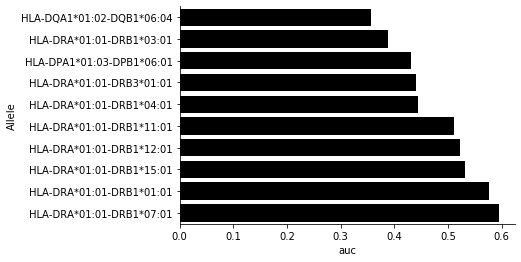

In [33]:
scores_df = []
to_score = validation_df.copy()
for allele, sub_validation_df in validation_df.groupby("hla"):
    to_score["hit"] = 0
    to_score.loc[sub_validation_df.index, "hit"] = 1
    scores_df.append((
        allele,
        sklearn.metrics.roc_auc_score(to_score.hit, -1 * to_score.prediction),
    ))

scores_df = pandas.DataFrame(scores_df, columns=["allele", "auc"])
scores_df = scores_df.sort_values("auc")

seaborn.barplot(data=scores_df, y="allele", x="auc", color='black')
#pyplot.xlim(xmin=0.5)
pyplot.ylabel("Allele")
seaborn.despine()
scores_df

In [31]:
to_score

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,original_pmid,pulldown_antibody,sample_type,proteins_human,proteins_mouse,proteins_viral,parsed_allele,alpha_allele,beta_allele,prediction,hit
28064,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,3133.608159,0
28065,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|O95479-2|G6PE-2_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,2620.953567,0
28066,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,NaN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,52.458821,0
28067,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|P09912-2|IFI6-2_HUMAN sp|P09912-3|IFI6-3_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,902.272042,0
28068,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q9UII2-2|ATIF1-2_HUMAN sp|Q9UII2-3|ATIF1-3_...,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,5526.197589,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73695,31495665,MAPTAC_DRB1*15:01,AQNVGTTHDL,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,tr|J3KS79|J3KS79_HUMAN tr|K7ENH5|K7ENH5_HUMAN ...,tr|E9PZH4|E9PZH4_MOUSE tr|E9Q6V3|E9Q6V3_MOUSE,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,3087.319337,0
73696,31495665,MAPTAC_DRB1*15:01,YPHRPVLMVISHAAPHGPE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q8IWU5-2|SULF2-2_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,18.817918,0
73697,31495665,MAPTAC_DRB1*15:01,KQERISRYQGVNLYIKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,tr|H0YEU6|H0YEU6_HUMAN tr|H0Y5F5|H0Y5F5_HUMAN ...,tr|A3KFU5|A3KFU5_MOUSE tr|A3KFU8|A3KFU8_MOUSE ...,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,201.990601,0
73698,31495665,MAPTAC_DRB1*15:01,QDEHFLGIESLWNHKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,31495665,MAPTAC,EXPI293,sp|Q8IY82-2|DRC7-2_HUMAN tr|H3BRR8|H3BRR8_HUMAN,NaN,NaN,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,143.350136,0


In [32]:
validation_df.original_pmid.value_counts()

31495665    45493
Name: original_pmid, dtype: int64